# DECISION TREE

In [1]:
import pandas as pd 

df_scaled = pd.read_csv('../data/scaled_data.csv')
df_not_scaled = pd.read_csv('../data/not_scaled_data.csv')

In [2]:
from sklearn import metrics
import numpy as np

def calc_median_absolute_percentage_error(y_true, y_pred):
    return np.median(np.abs((y_true - y_pred) / y_true)) * 100

def calculate_metrics(y_pred, y_test):
    r2 = metrics.r2_score(y_test, y_pred)
    smse = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
    mean_ae = metrics.mean_absolute_error(y_test, y_pred)
    mean_ape = metrics.mean_absolute_percentage_error(y_test, y_pred)
    median_ae = metrics.median_absolute_error(y_test, y_pred)
    median_ape = calc_median_absolute_percentage_error(y_test, y_pred)
    return [r2, smse, mean_ae, mean_ape, median_ae, median_ape]
    
def within_x_percent(y_pred, y_test, x):
    return np.sum(np.abs((y_pred - y_test)/y_test) < x) / len(y_test) * 100

def show_metrics(y_pred, y_test, target_scaler = None, logarithm = False):        
    metrics_df = pd.DataFrame(columns=['Target', 'R2', 'Root Mean Squared Error', 'Mean Absolute Error',
                                            'Mean Absolute Percentage Error', 'Median Absolute Error', 'Median Absolute Percentage Error'])
    
    metrics_df.loc[0] = ['Target is scaled'] + calculate_metrics(y_pred, y_test)
    
    if target_scaler:
        y_pred = target_scaler.inverse_transform(y_pred.reshape(-1, 1)).flatten()
        y_test = target_scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()
        metrics_df.loc[1] = ['Scaled Target is inversed to real value'] + calculate_metrics(y_pred, y_test)

    
    if logarithm and target_scaler:
        y_pred = np.power(10, y_pred)
        y_test = np.power(10, y_test)
        metrics_df.loc[2] = ['Target -> 10 ^ Target'] + calculate_metrics(y_pred, y_test)
    
    dist_df = pd.DataFrame({"within 5%": [within_x_percent(y_pred, y_test, 0.05)],
                    "within 10%": [within_x_percent(y_pred, y_test, 0.10)],
                    "within 20%": [within_x_percent(y_pred, y_test, 0.20)],
                    "within 50%": [within_x_percent(y_pred, y_test, 0.50)],
                    "median absolute percentage error": [calc_median_absolute_percentage_error(y_test, y_pred)]}, index=['Percentage'])
        
    display(metrics_df)
    display(dist_df)

In [3]:
from abc import ABC, abstractmethod
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeRegressor

class RegressionModel(ABC):
    def __init__(self, features, target, params, scale=True, logarithm=False):
        if scale:
            self.feature_scaler = StandardScaler()
            self.target_scaler = StandardScaler()
            self.features = self.feature_scaler.fit_transform(features)
            self.target = self.target_scaler.fit_transform(target.values.reshape(-1, 1)).flatten()
        else:
            self.feature_scaler = None
            self.target_scaler = None
            self.features = features
            self.target = target.values.flatten()
            
        self.logarithm = logarithm
        
        X_train, X_test, y_train, y_test = train_test_split(self.features, self.target, test_size=0.2, random_state=42)
        self.X_train = X_train
        self.X_test = X_test
        self.y_train = y_train
        self.y_test = y_test

        self.model = self.create_model(params)
        self.search_params = self.set_search_params()
        self.model.fit(X_train, y_train)
        self.y_pred = self.model.predict(X_test)
        
    @abstractmethod
    def create_model(self, params):
        pass
    
    @abstractmethod
    def set_search_params(self):
        pass
    
    def predict(self, features):
        if self.feature_scaler:
           features = self.feature_scaler.transform(features)
        return self.model.predict(features)
    
    def grid_search(self):
        grid_search = GridSearchCV(self.model, self.search_params, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1)
        grid_search.fit(self.X_train, self.y_train)
        best_model = grid_search.best_estimator_
        test_score = best_model.score(self.X_test, self.y_test)
        self.model = best_model
        self.y_pred = self.model.predict(self.X_test)
        return best_model, test_score
    
    def show_metrics(self):
        show_metrics(self.y_pred, self.y_test, self.target_scaler, self.logarithm)
    
    def draw_predictions(self, log=False):
        if self.target_scaler:
            y_pred = self.target_scaler.inverse_transform(self.y_pred.reshape(-1, 1)).ravel()
            y_test = self.target_scaler.inverse_transform(self.y_test.reshape(-1, 1)).ravel()
        else:
            y_pred = self.y_pred
            y_test = self.y_test
        
        if log:
            y_pred = np.power(10, y_pred)
            y_test = np.power(10, y_test)
        
        plt.figure(figsize=(10, 6))
        sns.scatterplot(x=y_test, y=y_pred, color='blue', label='Predicted vs Actual')
        plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label='Ideal Fit')
        plt.title('Actual vs Predicted Values')
        plt.xlabel('Actual Values')
        plt.ylabel('Predicted Values')
        plt.legend()
        plt.show()

,Target,R2,Root Mean Squared Error,Mean Absolute Error,Mean Absolute Percentage Error,Median Absolute Error,Median Absolute Percentage Error
0,Target is scaled,0.867142,0.372225,0.265814,1.244362,0.180259,30.119875
1,Scaled Target is inversed to real value,0.867142,0.101863,0.072743,0.012015,0.049330,0.825996
2,Target -> 10 ^ Target,0.846734,494547.434664,251347.230961,0.171895,124782.557551,11.571018


,within 5%,within 10%,within 20%,within 50%,median absolute percentage error
Percentage,23.231257,44.878564,70.116156,95.776135,11.571018


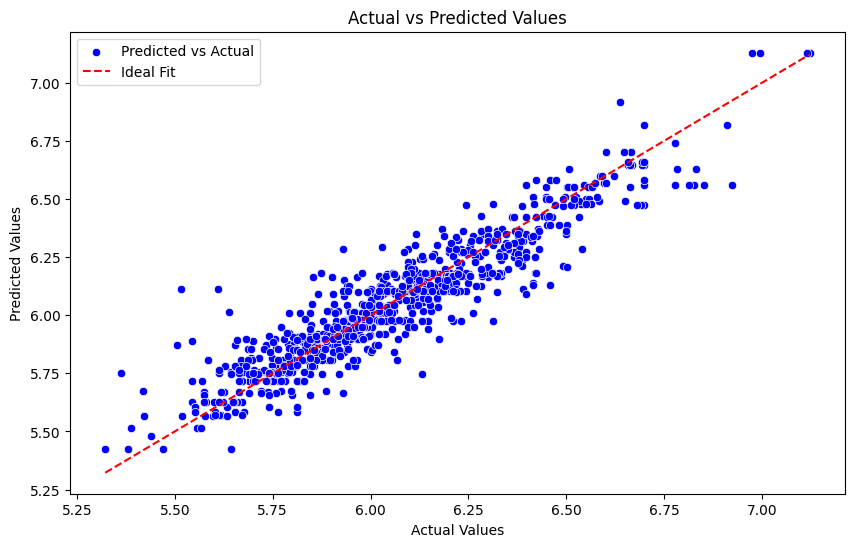

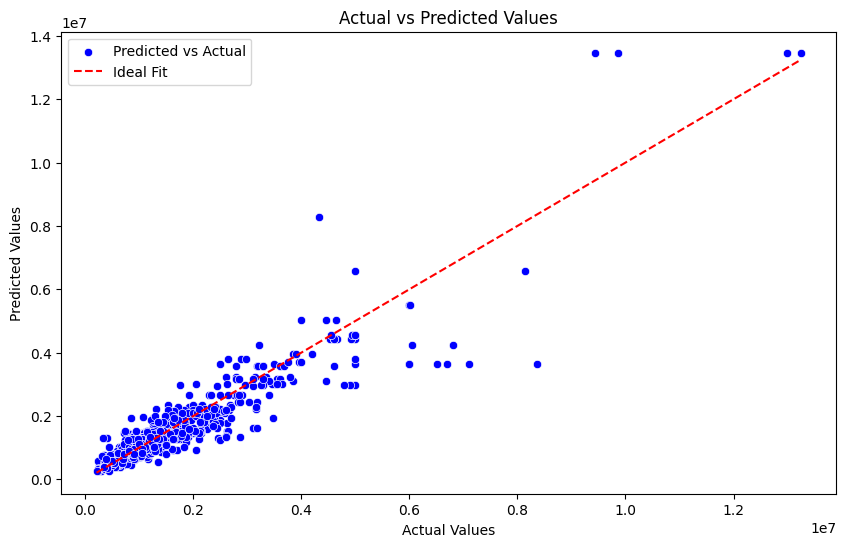

In [71]:
class DecisionTreeModel(RegressionModel):
    def create_model(self, params):
        return DecisionTreeRegressor(**params)
    
    def set_search_params(self):
        return {
            'max_depth': [None, 10, 20, 30, 40, 50],
            'min_samples_split': [2, 5, 10, 20],
            'min_samples_leaf': [1, 2, 5, 10],
            'max_features': [None, 'sqrt', 'log2']
        }

features = df_not_scaled[["rentZestimate", 'zipcode','hasView', "log_taxAssessedValue", "log_livingAreaValue", "log_lotAreaValue",
                           "lotAreaValue", "livingAreaValue", 
                          'hasCooling']]
target = df_not_scaled['log_price']
model = DecisionTreeModel(features, target, params={'max_depth': 10, 'min_samples_split': 10, 'min_samples_leaf': 10}, scale=True, logarithm=True)
model.show_metrics()
model.draw_predictions()
model.draw_predictions(log=True)


In [8]:
model.grid_search()

(DecisionTreeRegressor(max_depth=10, min_samples_leaf=5, min_samples_split=5),
 0.8604916732372474)

,Target,R2,Root Mean Squared Error,Mean Absolute Error,Mean Absolute Percentage Error,Median Absolute Error,Median Absolute Percentage Error
0,Target is scaled,0.827107,0.370168,0.180075,0.994442,0.094706,23.580969
1,Scaled Target is inversed to real value,0.827107,525259.743908,255522.582235,0.189837,134385.746667,12.477067


,within 5%,within 10%,within 20%,within 50%,median absolute percentage error
Percentage,20.168955,40.760296,68.215417,93.980993,12.477067


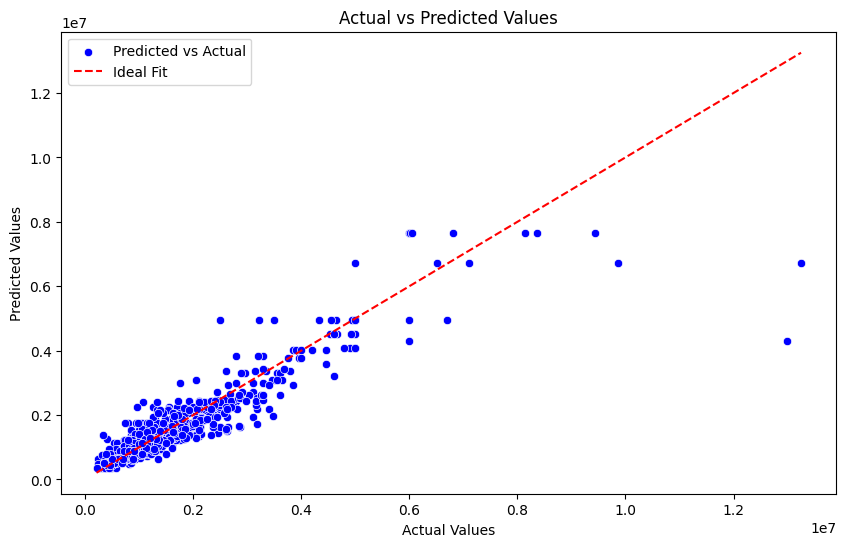

In [59]:
class DecisionTreeModel(RegressionModel):
    def create_model(self, params):
        return DecisionTreeRegressor(**params)
    
    def set_search_params(self):
        return {
            'max_depth': [None, 10, 20, 30, 40, 50],
            'min_samples_split': [2, 5, 10, 20],
            'min_samples_leaf': [1, 2, 5, 10],
            'max_features': [None, 'sqrt', 'log2']
        }

features = df_not_scaled[["rentZestimate", 'zipcode','hasView', "log_taxAssessedValue", "log_livingAreaValue", "log_lotAreaValue",
                           "lotAreaValue", "livingAreaValue", "parkingCapacity", 
                          'hasCooling']]
target = df_not_scaled['price']
model = DecisionTreeModel(features, target, params={'max_depth': 10, 'min_samples_split': 10, 'min_samples_leaf': 10}, scale=True, logarithm=False)
model.show_metrics()
model.draw_predictions()
